In [223]:
import numpy as np
from collections import Counter
import json
import math
import os.path

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import f1_score
from sklearn import preprocessing

import datetime
import time
import nltk

In [3]:
def getExistence(source_tweets, filePath):
#@@ Param:  Source_tweets: a list of source tweets ID
#           filePath: source tweets  parent document directory
#@@ Return: an n x 2 array, n is the amount/number of source tweets' IDs    
    
    existence = np.zeros((len(source_tweets),2))
    for i in range(len(source_tweets)):
        data = json.load(open(filePath+'/'+source_tweets[i]+'/source-tweet/'+source_tweets[i]+'.json','r'))
        if len(data['entities']['hashtags']) != 0:
            existence[i][0] = 1
        else:
            existence[i][0] = 0
        
        if len(data['entities']['urls']) != 0:
            existence[i][1] = 1
        else:
            existence[i][1] = 0
            
    return existence

In [4]:
# def getText(source_tweets, filePath):
# #@@ Param:  Source_tweets: a list of source tweets ID
# #           filePath: source tweets  parent document directory
# #@@ Return: tweets text coresspoding to source tweets' IDs   

#     tweet_text = []
#     for i in range(len(source_tweets)):
#         data = json.load(open(filePath+'/'+source_tweets[i]+'/source-tweet/'+source_tweets[i]+'.json','r'))
#         tweet_text += [[data['text']]]
    
#     return tweet_text

In [5]:
def getUserInfo(source_tweets,featureList,filePath):
    
    userFeatures = []
    for i in range(len(source_tweets)):
        data = json.load(open(filePath+'/'+source_tweets[i]+'/source-tweet/'+source_tweets[i]+'.json','r'))
        userData = [data['user'][feature] for feature in featureList]
        userData += [data['created_at']]
        userFeatures += [userData]
    
    return userFeatures

In [6]:
# extract features, Percentage of replying tweets classified as queries, denies or supports
def getPercentage(source_tweets, tweets_stances, filePath):
#@@ Param: source_tweets: a list of source tweets ID
#          tweets_stances：a list of stances, which contains all tweets' stance including reply tweets and source tweets
#          filePath: source tweets  parent document directory
#@@ Return: an n x 3 array, n is the amount/number of source tweets' IDs
   
    stance_list = []
    for tweet_ID in source_tweets:
        replies_json_list = os.listdir(filePath+'/'+tweet_ID+'/replies') # make a list of reply tweets' IDs .json
        replies_list = [dot_json.split('.')[0] for dot_json in replies_json_list] # remove filename suffixes '.json'
        tmp = []
        for reply_ID in replies_list:
            tmp_stance = tweets_stances[reply_ID]
            tmp += [tmp_stance]
        stance_list += [tmp]
    
    
    stance_percentage = np.zeros((len(stance_list),3)) # initialise an array, column 0,1,2 are percentages of query, deny, support
    
    for i in range(len(stance_list)):
        count = Counter(stance_list[i])
        l = len(stance_list[i])
        if 'query' in count:
            stance_percentage[i][0] = count['query']/l
        else:
            stance_percentage[i][0] = 0 
        
        if 'deny' in count:
            stance_percentage[i][1] = count['deny']/l
        else:
            stance_percentage[i][1] = 0 
        
        if 'support' in count:
            stance_percentage[i][2] = count['support']/l
        else:
            stance_percentage[i][2] = 0 
    
    return stance_percentage

In [7]:
#transfer label
def str2no(y_string):
#@@ Param: a list of rumour veracity labels, each element is a string
#@@ Return: a list of label, each element is an int; 0,1,2 represent 'unverified','false','true' respectively
    
    y = []
    for cls in y_string:
        if cls=='unverified':
            y += [0]
        elif cls=='false':
            y += [1]
        elif cls=='true':
            y += [2]
    return y

In [55]:
def transferUserInfo(userInfo):
    results = np.zeros((len(userInfo),len(userInfo[0])-1),dtype=int)
    for i in range(len(userInfo)):
        #if it has been verified
        if userInfo[i][0]==False:
            results[i][0] = 0
        else:
            results[i][0] = 1
        
        #if it has location?               
        if userInfo[i][1]=='' or userInfo[i][1]==None:
            results[i][1] = 0
        else:
            results[i][1] = 1
            
        #if it has description?
        if userInfo[i][2]=='' or userInfo[i][2]==None:
            results[i][2] = 0
        else:
            results[i][2] = 1

        #how many followers? followers_count
        results[i][3] = userInfo[i][3]               
        #how many people it follows? friends_count
        results[i][4] = userInfo[i][4]
        #how many tweets it posted? statuses_count
        results[i][5] = userInfo[i][5]    
        # favourites_count
        results[i][6] = userInfo[i][6]
        #how many days, after creating this account, when he/she posted this tweet
        tp = time.strptime(userInfo[i][-1],"%a %b %d %H:%M:%S %z %Y")
        tc = time.strptime(userInfo[i][-2],"%a %b %d %H:%M:%S %z %Y")
        diff = (datetime.datetime(tp.tm_year, tp.tm_mon, tp.tm_mday) - datetime.datetime(tc.tm_year, tc.tm_mon, tc.tm_mday)).days
        results[i][7] = diff
        
    return results

In [269]:
def scorer(y_truth, y_hat, confidence): # rumourEval 2019 version of scorer
#@ Param:  y_truth: a list of true labels
#          y_hat: a list of predicted y values
#          confidence: a list of confidence values related to y_hat
# Return: accuracy score, RMSE and Macro averaged F1 score
    
    correct = 0
    total = len(y_hat)
    errors = []
    y_pred = []
    
    for i in range(total):
        if confidence[i]>0.5:
                y_pred += [y_hat[i]]
        else:
                y_pred += [0]   
        
        if y_pred[i] == y_truth[i] and y_truth[i]!=0:
            correct += 1
            errors += [(1-confidence[i])**2]

        elif y_truth[i] == 0:
            errors += [ (confidence[i])**2 ]

        else:
            errors += [1.0]
            
    score = correct / total
    rmse = math.sqrt( sum(errors) / len(errors) )
    macroF = f1_score(y_truth, y_pred, average='macro')

    return score,rmse,macroF

In [218]:
# the U,T,F of the source post
train_file = './rumoureval-2019-training-data/train-key.json'
f = json.load(open(train_file, 'r'))

# extract features, hashtag existence and URL existence
filePath = './rumoureval-2019-training-data/twitter-english'

In [219]:
#extract train data

source_tweets_train = list(f['subtaskbenglish'].keys()) # make a list of source tweets' ID

# a dictionary of tweets' stances
tweets_stances_train = f['subtaskaenglish'] ################## train and dev data are using same datasets


features = ['verified', 'location', 'description', 'followers_count',  ####################user feature we need
                                  'friends_count', 'statuses_count', "favourites_count",'created_at']

userInfoString = getUserInfo(source_tweets_train,features,filePath)
#  hashtag existence, URL existence, percentage of queries, denies, supports
existence = getExistence(source_tweets_train, filePath)
qds_percentage = getPercentage(source_tweets_train, tweets_stances_train, filePath)
ue_train = transferUserInfo(userInfoString)

y_train_string = list(f['subtaskbenglish'].values())

In [220]:
# preprocessing tweets' texts
# train_text = getText(source_tweets_train, filePath)
# train_text

In [221]:
X_train = np.hstack((np.hstack((existence,qds_percentage)),ue_train)) ################# X_train : existence + qds_percent + userInfo
y_train = str2no(y_train_string) #################### y_train

In [59]:
userInfoString[0]

[False,
 'MIAMI',
 'YO WE HACK DIS NIGGA',
 18662,
 36,
 153,
 20,
 'Tue Aug 12 06:41:41 +0000 2014',
 'Fri Aug 15 14:30:12 +0000 2014']

In [60]:
ue_train[0]

array([    0,     1,     1, 18662,    36,   153,    20,     3])

In [224]:
############################normalize the training data
scaler = preprocessing.StandardScaler().fit(X_train) 
X_train = scaler.transform(X_train)

In [225]:
#extract dev data

dev_file = './rumoureval-2019-training-data/dev-key.json'
f = json.load(open(dev_file, 'r'))

source_tweets_dev = list(f['subtaskbenglish'].keys())
y_dev_string = list(f['subtaskbenglish'].values())
tweets_stances_dev = f['subtaskaenglish']

userInfoString = getUserInfo(source_tweets_dev,features,filePath)

existence = getExistence(source_tweets_dev, filePath)
qds_percentage = getPercentage(source_tweets_dev, tweets_stances_dev, filePath)
ue_dev = transferUserInfo(userInfoString)

In [226]:
X_dev = np.hstack((np.hstack((existence,qds_percentage)),ue_dev)) ################# X_dev
X_dev = scaler.transform(X_dev) ######################## normalize dev data
y_dev = np.array(str2no(y_dev_string)) ################# y_dev

In [227]:
#extract test data

te_Path = './rumoureval-2019-test-data/twitter-en-test-data'

f = json.load(open('./final-eval-key.json', 'r'))

source_tweets_te = list(f['subtaskbenglish'].keys())
y_te_string = list(f['subtaskbenglish'].values())
tweets_stances_te = f['subtaskaenglish']

userInfoString = getUserInfo(source_tweets_te,features,te_Path)

existence = getExistence(source_tweets_te, te_Path)
qds_percentage = getPercentage(source_tweets_te, tweets_stances_te, te_Path)
ue_test = transferUserInfo(userInfoString)

In [228]:
X_te = np.hstack((np.hstack((existence,qds_percentage)),ue_test)) ################# X_te
X_te = scaler.transform(X_te)####################normalize test data
y_te = np.array(str2no(y_te_string))

In [66]:
source_tweets_te[2],X_te[2]

('784071228248109057',
 array([-1.35224681,  1.01015254, -0.7587507 , -0.64642815, -0.87314786,
         0.7124705 ,  0.46070044,  0.0823387 ,  0.08683074, -0.29309496,
        -0.22561009, -0.24225107,  1.4671842 ]))

In [80]:
clf = RandomForestClassifier(n_estimators=200)
clf.fit(X=X_train, y=y_train)
sig_clf = CalibratedClassifierCV(clf,method='isotonic', cv='prefit')
sig_clf.fit(X_dev,y_dev)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(n_estimators=200),
                       cv='prefit', method='isotonic')

In [81]:
sig_clf_probs = sig_clf.predict_proba(X_te) 

y_hat = sig_clf.predict(X_te) ######################### predicted label as 3 classes

In [82]:
y_hat

array([2, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 2, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 1, 1, 0, 1, 1, 1, 1, 0, 1, 2, 1])

In [83]:
clf_confidence = np.zeros(y_hat.shape) ##################### confidence value for each piece of prediction

for i in range(len(y_hat)):
    if y_hat[i]!=0:
        clf_confidence[i] = sig_clf_probs[i][y_hat[i]]
    else:
        if sig_clf_probs[i][1]>=sig_clf_probs[i][2]:
            clf_confidence[i] = sig_clf_probs[i][1]
            y_hat[i] = 1
        else:
            clf_confidence[i] = sig_clf_probs[i][2]
            y_hat[i] = 2

In [84]:
y_hat ###################### after processing, y_hat should only contains 2 classes

array([2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1])

In [85]:
clf_confidence

array([0.5483871 , 0.48611111, 0.625     , 0.58659218, 0.88235294,
       0.51554828, 0.5257732 , 0.53846154, 0.36170213, 0.68      ,
       0.68881686, 0.5862069 , 0.90909091, 0.54054054, 0.68      ,
       0.73913043, 0.38461538, 0.90909091, 0.36480687, 0.68      ,
       0.5862069 , 0.5862069 , 0.68      , 0.90909091, 0.73913043,
       0.68      , 0.55944056, 0.68      , 0.        , 0.73913043,
       0.66077739, 0.88235294, 0.68      , 0.68      , 0.68      ,
       0.36170213, 0.68      , 0.73913043, 0.90909091, 0.73913043,
       0.71257485, 0.90909091, 0.69716088, 0.43664384, 0.47577093,
       0.71970803, 0.68      , 0.42857143, 0.68      , 0.58659218,
       0.88235294, 0.90909091, 0.36170213, 0.88235294, 0.43664384,
       0.58659218])

In [272]:
def scorer(y_truth, y_hat, confidence): # rumourEval 2019 version of scorer
#@ Param:  y_truth: a list of true labels
#          y_hat: a list of predicted y values
#          confidence: a list of confidence values related to y_hat
# Return: accuracy score, RMSE and Macro averaged F1 score
    
    correct = 0
    total = len(y_hat)
    errors = []
    y_pred = []
    
    for i in range(total):
        if confidence[i]>0.5:
                y_pred += [y_hat[i]]
        else:
                y_pred += [0]   
        
        if y_pred[i] == y_truth[i] and y_truth[i]!=0:
            correct += 1
            errors += [(1-confidence[i])**2]

        elif y_truth[i] == 0:
            errors += [ (confidence[i])**2 ]

        else:
            errors += [1.0]
    
    score = correct / total
    rmse = math.sqrt( sum(errors) / len(errors) )
    macroF = f1_score(y_truth, y_pred, average='macro')

    return score,rmse,macroF,y_pred

In [86]:
score,rmse,macroF = scorer(y_te,y_hat,clf_confidence) # F-score is ill-defined and being set to 0.0 in labels with no predicted samples
print('accuracy:', score)
print('RMSE:', rmse)
print('Macro averaged F1 socre:', macroF)

accuracy: 0.5
RMSE: 0.710266587367439
Macro averaged F1 socre: 0.3717813051146384


In [97]:
rmse_list = []
macroF_list = []
esnum_list = []

for estimator_num in range(100,5000,100):
    
    clf = RandomForestClassifier(n_estimators=estimator_num)
    clf.fit(X=X_train, y=y_train)
    sig_clf = CalibratedClassifierCV(clf,method='isotonic', cv='prefit')
    sig_clf.fit(X_dev,y_dev)
    
    sig_clf_probs = sig_clf.predict_proba(X_dev) 

    y_hat = sig_clf.predict(X_dev) ######################### predicted label as 3 classes

    clf_confidence = np.zeros(y_hat.shape) ##################### confidence value for each piece of prediction

    for i in range(len(y_hat)):
        if y_hat[i]!=0:
            clf_confidence[i] = sig_clf_probs[i][y_hat[i]]
        else:
            if sig_clf_probs[i][1]>=sig_clf_probs[i][2]:
                clf_confidence[i] = sig_clf_probs[i][1]
                y_hat[i] = 1
            else:
                clf_confidence[i] = sig_clf_probs[i][2]
                y_hat[i] = 2
    
    score,rmse,macroF = scorer(y_dev,y_hat,clf_confidence)
    
    esnum_list += [estimator_num]
    rmse_list += [rmse]
    macroF_list += [macroF]

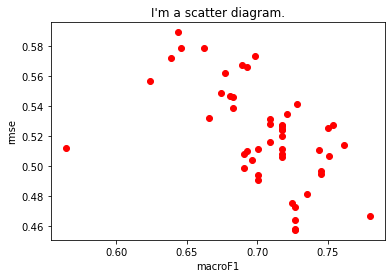

In [99]:
import matplotlib.pyplot as plt
plt.title("I'm a scatter diagram.") 
# plt.xlim(xmax=7,xmin=0)
# plt.ylim(ymax=7,ymin=0)
plt.plot(macroF_list,rmse_list,'ro')
plt.xlabel("macroF1")
plt.ylabel("rmse")
plt.show()

In [100]:
rmse_list.index(min(rmse_list))

18

In [101]:
esnum_list[18]

1900

In [281]:
clf = RandomForestClassifier(n_estimators=1900)
clf.fit(X=X_train, y=y_train)
sig_clf = CalibratedClassifierCV(clf,method='isotonic', cv='prefit')
sig_clf.fit(X_dev,y_dev)

sig_clf_probs = sig_clf.predict_proba(X_te) 

y_hat = sig_clf.predict(X_te) ######################### predicted label as 3 classes

clf_confidence = np.zeros(y_hat.shape) ##################### confidence value for each piece of prediction

for i in range(len(y_hat)):
    if y_hat[i]!=0:
        clf_confidence[i] = sig_clf_probs[i][y_hat[i]]
    else:
        if sig_clf_probs[i][1]>=sig_clf_probs[i][2]:
            clf_confidence[i] = sig_clf_probs[i][1]
            y_hat[i] = 1
        else:
            clf_confidence[i] = sig_clf_probs[i][2]
            y_hat[i] = 2




score,rmse,macroF, y_pred = scorer(y_te,y_hat,clf_confidence) # F-score is ill-defined and being set to 0.0 in labels with no predicted samples
print('accuracy:', score)
print('RMSE:', rmse)
print('Macro averaged F1 socre:', macroF)

accuracy: 0.5535714285714286
RMSE: 0.6786281494657567
Macro averaged F1 socre: 0.36624153676586363


In [70]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.figure

In [109]:
print(y_pred)

[2, 0, 2, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]


In [110]:
print(y_te)

[2 2 2 2 2 2 1 1 1 2 1 1 1 0 1 1 1 1 1 1 2 2 1 2 1 1 2 1 1 2 2 1 2 2 1 2 1
 1 1 0 0 1 1 1 0 1 2 1 1 1 1 2 2 2 2 2]


In [280]:
classification_report?

In [282]:
print(confusion_matrix(y_te,y_pred))
print(classification_report(y_te,y_pred))

[[ 0  3  1]
 [ 5 25  0]
 [ 1 15  6]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.58      0.83      0.68        30
           2       0.86      0.27      0.41        22

    accuracy                           0.55        56
   macro avg       0.48      0.37      0.37        56
weighted avg       0.65      0.55      0.53        56



In [26]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [30]:
X_train[10]

array([ 0.73950997, -0.98994949, -0.7587507 ,  2.38376936, -0.28345653,
       -1.40356688,  0.46070044,  0.0823387 , -0.44030477, -0.3051479 ,
       -0.77025588, -1.14784625,  0.        ])

In [ ]:
categorical_columns = ['verified', 'location', 'description']
numerical_columns = ['query%','deny%','support%','followers_count','friends_count', 'statuses_count', "favourites_count",'created_at']


In [234]:
clf.feature_importances_

array([0.02689759, 0.01821295, 0.08355248, 0.09552629, 0.11152191,
       0.02359755, 0.01970984, 0.00081777, 0.13027628, 0.11903471,
       0.12592956, 0.12657088, 0.11835219])

<AxesSubplot:>

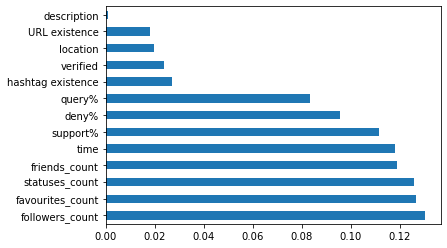

In [239]:
columns = ['hashtag existence', 'URL existence','query%','deny%','support%','verified', 'location', 'description',
                       'followers_count','friends_count', 'statuses_count', "favourites_count",'time']
feat_importances = pd.Series(clf.feature_importances_, index= columns)
feat_importances.nlargest(13).plot(kind='barh')



In [244]:
def transferUserInfo(userInfo): ###########第二版
    results = np.zeros((len(userInfo),5),dtype=int)
    for i in range(len(userInfo)):
        #if it has been verified
#         if userInfo[i][0]==False:
#             results[i][0] = 0
#         else:
#             results[i][0] = 1
        
#         #if it has location?               
#         if userInfo[i][1]=='' or userInfo[i][1]==None:
#             results[i][1] = 0
#         else:
#             results[i][1] = 1
            
#         #if it has description?
#         if userInfo[i][2]=='' or userInfo[i][2]==None:
#             results[i][2] = 0
#         else:
#             results[i][2] = 1

        #how many followers? followers_count
        results[i][0] = userInfo[i][3]               
        #how many people it follows? friends_count
        results[i][1] = userInfo[i][4]
        #how many tweets it posted? statuses_count
        results[i][2] = userInfo[i][5]    
        # favourites_count
        results[i][3] = userInfo[i][6]
        #how many days, after creating this account, when he/she posted this tweet
        tp = time.strptime(userInfo[i][-1],"%a %b %d %H:%M:%S %z %Y")
        tc = time.strptime(userInfo[i][-2],"%a %b %d %H:%M:%S %z %Y")
        diff = (datetime.datetime(tp.tm_year, tp.tm_mon, tp.tm_mday) - datetime.datetime(tc.tm_year, tc.tm_mon, tc.tm_mday)).days
        results[i][4] = diff
        
    return results

In [245]:
# the U,T,F of the source post
train_file = './rumoureval-2019-training-data/train-key.json'
f = json.load(open(train_file, 'r'))

# extract features, hashtag existence and URL existence
filePath = './rumoureval-2019-training-data/twitter-english'

#extract train data

source_tweets_train = list(f['subtaskbenglish'].keys()) # make a list of source tweets' ID

# a dictionary of tweets' stances
tweets_stances_train = f['subtaskaenglish'] ################## train and dev data are using same datasets


features = ['verified', 'location', 'description', 'followers_count',  ####################user feature we need
                                  'friends_count', 'statuses_count', "favourites_count",'created_at']

userInfoString = getUserInfo(source_tweets_train,features,filePath)
#  hashtag existence, URL existence, percentage of queries, denies, supports
existence = getExistence(source_tweets_train, filePath)
qds_percentage = getPercentage(source_tweets_train, tweets_stances_train, filePath)
ue_train = transferUserInfo(userInfoString)

y_train_string = list(f['subtaskbenglish'].values())

X_train = np.hstack((qds_percentage,ue_train)) ################# X_train : existence + qds_percent + userInfo
y_train = str2no(y_train_string) #################### y_train

scaler = preprocessing.StandardScaler().fit(X_train) 
X_train = scaler.transform(X_train)

In [246]:
len(X_train[0])

8

In [247]:
dev_file = './rumoureval-2019-training-data/dev-key.json'
f = json.load(open(dev_file, 'r'))

source_tweets_dev = list(f['subtaskbenglish'].keys())
y_dev_string = list(f['subtaskbenglish'].values())
tweets_stances_dev = f['subtaskaenglish']

userInfoString = getUserInfo(source_tweets_dev,features,filePath)

existence = getExistence(source_tweets_dev, filePath)
qds_percentage = getPercentage(source_tweets_dev, tweets_stances_dev, filePath)
ue_dev = transferUserInfo(userInfoString)

X_dev =  np.hstack((qds_percentage,ue_dev)) ################# X_dev
X_dev = scaler.transform(X_dev) ######################## normalize dev data
y_dev = np.array(str2no(y_dev_string)) ################# y_dev

In [248]:
te_Path = './rumoureval-2019-test-data/twitter-en-test-data'

f = json.load(open('./final-eval-key.json', 'r'))

source_tweets_te = list(f['subtaskbenglish'].keys())
y_te_string = list(f['subtaskbenglish'].values())
tweets_stances_te = f['subtaskaenglish']

userInfoString = getUserInfo(source_tweets_te,features,te_Path)

existence = getExistence(source_tweets_te, te_Path)
qds_percentage = getPercentage(source_tweets_te, tweets_stances_te, te_Path)
ue_test = transferUserInfo(userInfoString)

X_te =  np.hstack((qds_percentage,ue_test)) ################# X_te
X_te = scaler.transform(X_te)####################normalize test data
y_te = np.array(str2no(y_te_string))

In [270]:
rmse_list = []
macroF_list = []
esnum_list = []

for estimator_num in range(100,8000,100):
    
    clf = RandomForestClassifier(n_estimators=estimator_num)
    clf.fit(X=X_train, y=y_train)
    sig_clf = CalibratedClassifierCV(clf,method='sigmoid', cv='prefit')
    sig_clf.fit(X_dev,y_dev)
    
    sig_clf_probs = sig_clf.predict_proba(X_dev) 

    y_hat = sig_clf.predict(X_dev) ######################### predicted label as 3 classes

    clf_confidence = np.zeros(y_hat.shape) ##################### confidence value for each piece of prediction

    for i in range(len(y_hat)):
        if y_hat[i]!=0:
            clf_confidence[i] = sig_clf_probs[i][y_hat[i]]
        else:
            if sig_clf_probs[i][1]>=sig_clf_probs[i][2]:
                clf_confidence[i] = sig_clf_probs[i][1]
                y_hat[i] = 1
            else:
                clf_confidence[i] = sig_clf_probs[i][2]
                y_hat[i] = 2
    
    score,rmse,macroF = scorer(y_dev,y_hat,clf_confidence)
    
    esnum_list += [estimator_num]
    rmse_list += [rmse]
    macroF_list += [macroF]

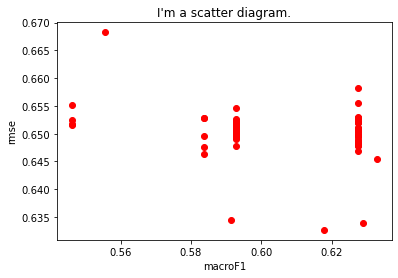

In [271]:
import matplotlib.pyplot as plt
plt.title("I'm a scatter diagram.") 
# plt.xlim(xmax=7,xmin=0)
# plt.ylim(ymax=7,ymin=0)
plt.plot(macroF_list,rmse_list,'ro')
plt.xlabel("macroF1")
plt.ylabel("rmse")
plt.show()

In [273]:
np.argmin(rmse_list)

1

In [275]:
esnum_list[1]

200

In [278]:
clf = RandomForestClassifier(n_estimators=200)
clf.fit(X=X_train, y=y_train)
sig_clf = CalibratedClassifierCV(clf,method='sigmoid', cv='prefit')
sig_clf.fit(X_dev,y_dev)

sig_clf_probs = sig_clf.predict_proba(X_te) 

y_hat = sig_clf.predict(X_te) ######################### predicted label as 3 classes

clf_confidence = np.zeros(y_hat.shape) ##################### confidence value for each piece of prediction

for i in range(len(y_hat)):
    if y_hat[i]!=0:
        clf_confidence[i] = sig_clf_probs[i][y_hat[i]]
    else:
        if sig_clf_probs[i][1]>=sig_clf_probs[i][2]:
            clf_confidence[i] = sig_clf_probs[i][1]
            y_hat[i] = 1
        else:
            clf_confidence[i] = sig_clf_probs[i][2]
            y_hat[i] = 2




score,rmse,macroF, y_pred = scorer(y_te,y_hat,clf_confidence) # F-score is ill-defined and being set to 0.0 in labels with no predicted samples
print('accuracy:', score)
print('RMSE:', rmse)
print('Macro averaged F1 socre:', macroF)

accuracy: 0.5
RMSE: 0.7228777435113863
Macro averaged F1 socre: 0.42544492544492546


In [279]:
print(confusion_matrix(y_te,y_pred))
print(classification_report(y_te,y_pred))

[[ 2  2  0]
 [ 6 23  1]
 [ 6 11  5]]
              precision    recall  f1-score   support

           0       0.14      0.50      0.22         4
           1       0.64      0.77      0.70        30
           2       0.83      0.23      0.36        22

    accuracy                           0.54        56
   macro avg       0.54      0.50      0.43        56
weighted avg       0.68      0.54      0.53        56



In [284]:
from sklearn.naive_bayes import GaussianNB

In [296]:
clf = GaussianNB()
clf.fit(X=X_train, y=y_train)
sig_clf = CalibratedClassifierCV(clf,method='sigmoid', cv='prefit')
sig_clf.fit(X_dev,y_dev)

sig_clf_probs = sig_clf.predict_proba(X_te) 

y_hat = sig_clf.predict(X_te) ######################### predicted label as 3 classes

clf_confidence = np.zeros(y_hat.shape) ##################### confidence value for each piece of prediction

for i in range(len(y_hat)):
    if y_hat[i]!=0:
        clf_confidence[i] = sig_clf_probs[i][y_hat[i]]
    else:
        if sig_clf_probs[i][1]>=sig_clf_probs[i][2]:
            clf_confidence[i] = sig_clf_probs[i][1]
            y_hat[i] = 1
        else:
            clf_confidence[i] = sig_clf_probs[i][2]
            y_hat[i] = 2




score,rmse,macroF, y_pred = scorer(y_te,y_hat,clf_confidence) # F-score is ill-defined and being set to 0.0 in labels with no predicted samples
print('accuracy:', score)
print('RMSE:', rmse)
print('Macro averaged F1 socre:', macroF)

accuracy: 0.35714285714285715
RMSE: 0.7899315181730395
Macro averaged F1 socre: 0.2875447522140569


In [297]:
print(confusion_matrix(y_te,y_pred)) ######NB
print(classification_report(y_te,y_pred))

[[ 3  1  0]
 [10 20  0]
 [12 10  0]]
              precision    recall  f1-score   support

           0       0.12      0.75      0.21         4
           1       0.65      0.67      0.66        30
           2       0.00      0.00      0.00        22

    accuracy                           0.41        56
   macro avg       0.26      0.47      0.29        56
weighted avg       0.35      0.41      0.37        56



C:\Users\Shawn\Anaconda3\envs\mlai19\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [298]:
clf = svm.LinearSVC(multi_class='ovr', C=50, max_iter=1000000)
clf.fit(X=X_train, y=y_train)
sig_clf = CalibratedClassifierCV(clf,method='sigmoid', cv='prefit')
sig_clf.fit(X_dev,y_dev)

sig_clf_probs = sig_clf.predict_proba(X_te) 

y_hat = sig_clf.predict(X_te) ######################### predicted label as 3 classes

clf_confidence = np.zeros(y_hat.shape) ##################### confidence value for each piece of prediction

for i in range(len(y_hat)):
    if y_hat[i]!=0:
        clf_confidence[i] = sig_clf_probs[i][y_hat[i]]
    else:
        if sig_clf_probs[i][1]>=sig_clf_probs[i][2]:
            clf_confidence[i] = sig_clf_probs[i][1]
            y_hat[i] = 1
        else:
            clf_confidence[i] = sig_clf_probs[i][2]
            y_hat[i] = 2




score,rmse,macroF, y_pred = scorer(y_te,y_hat,clf_confidence) # F-score is ill-defined and being set to 0.0 in labels with no predicted samples
print('accuracy:', score)
print('RMSE:', rmse)
print('Macro averaged F1 socre:', macroF)

accuracy: 0.42857142857142855
RMSE: 0.7526595971987946
Macro averaged F1 socre: 0.3227920227920228


In [299]:
print(confusion_matrix(y_te,y_pred)) ##########svm
print(classification_report(y_te,y_pred))

[[ 1  2  1]
 [ 8 21  1]
 [ 7 12  3]]
              precision    recall  f1-score   support

           0       0.06      0.25      0.10         4
           1       0.60      0.70      0.65        30
           2       0.60      0.14      0.22        22

    accuracy                           0.45        56
   macro avg       0.42      0.36      0.32        56
weighted avg       0.56      0.45      0.44        56



In [3]:
# [1,24,-2,0,0]
def func(arr):
    positive = 0
    negative = 0
    zeros = 0
    for num in arr:
        if num > 0:
            positive += 1
        elif num == 0:
            zeros += 1
        else:
            negative += 1
            
    return positive, negative, zeros

In [5]:
a = [1,24,-2,0,0]
func(a)

(2, 1, 2)

In [30]:
tmp = -6 / 132
-int(-tmp)

0

In [32]:
-6 / float(132)

-0.045454545454545456

In [ ]:
51.5